In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [8]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')
gaia = data.to_pandas()
print(gaia.shape)

rot_file = '../data/Table_Periodic.txt'
rot = pd.read_csv(rot_file)
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
print(df.shape)

ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (gaia[u'r_modality_flag'] == 1) & 
              (gaia[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]
print(ok.shape)

(195830, 101)
(33538, 112)
(30305,)


In [10]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../iso/mist/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.) & 
                    (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]
mist_ms2 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] > 8.11) & (mist['log10_isochrone_age_yr'] < 8.2))[0][::-1]


# but now I like MIST better for this I think
Mg_iso_mist = np.interp(df[u'bp_rp'].values[ok], mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
                        mist['Gaia_G_DR2Rev'].values[mist_ms1])

delta_mag_mist = Mg_iso_mist - (df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5)

dok = np.isfinite(delta_mag_mist)
dmag_lims = [[-0.1, 0.4], [0.5, 1.]]

# main sequence stars
msok = np.where((delta_mag_mist >= dmag_lims[0][0]) & 
                (delta_mag_mist <= dmag_lims[0][1]))[0]
print(msok.shape)


(16248,)


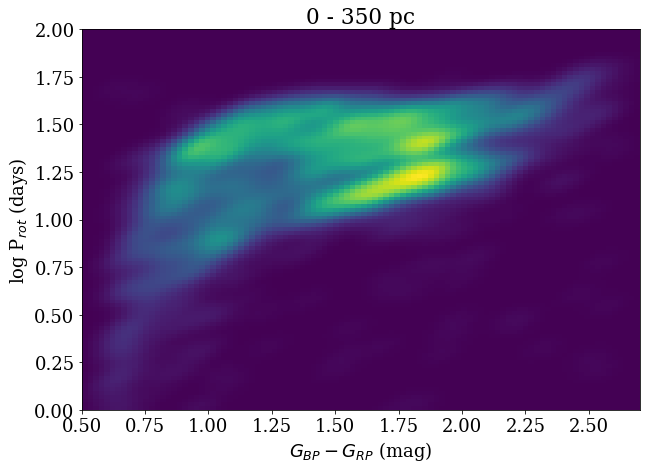

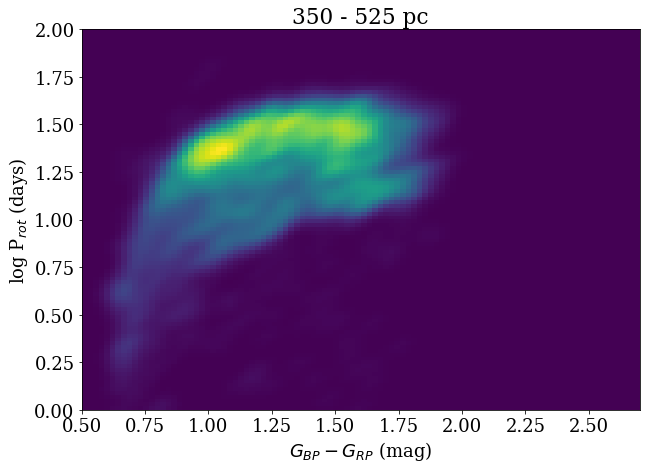

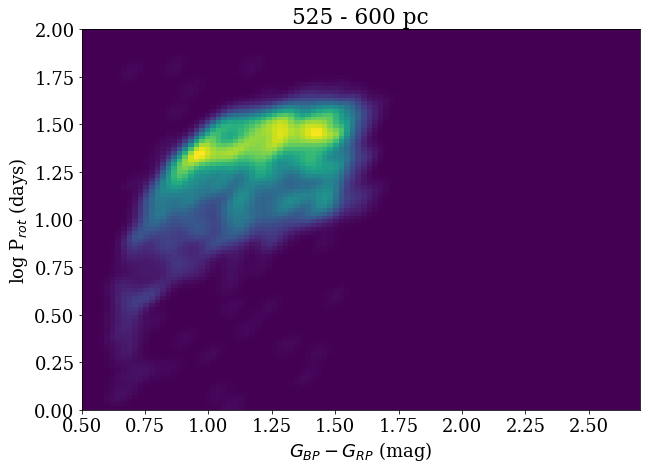

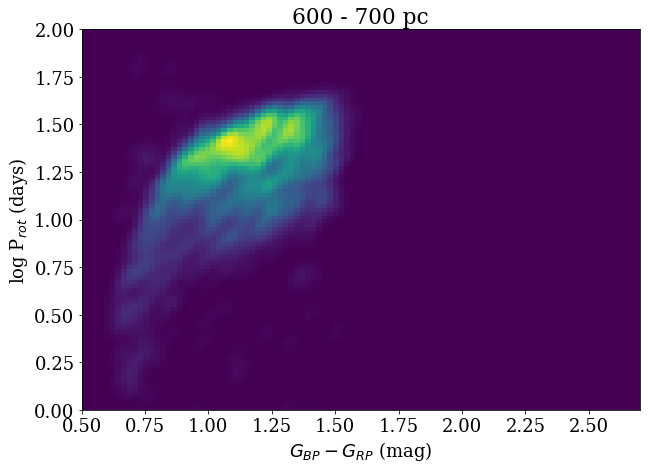

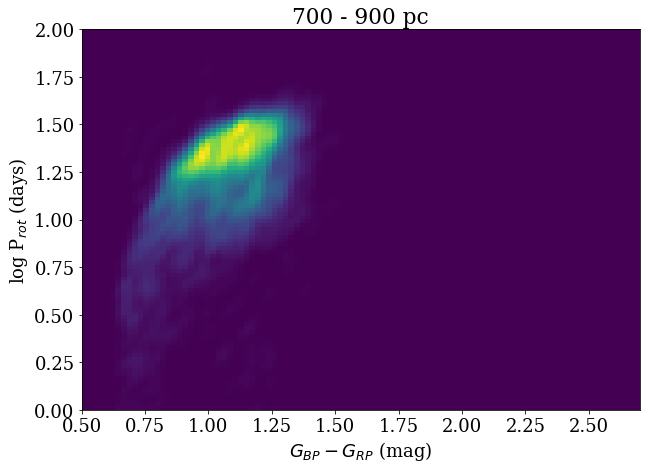

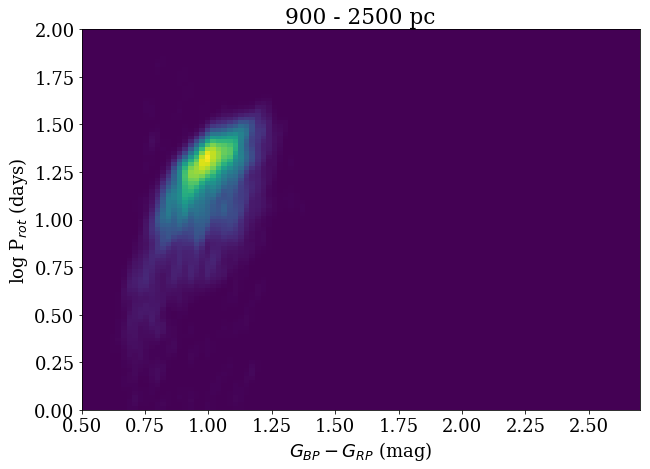

In [14]:
from scipy import stats

dist = df[u'r_est'].values[ok][msok]

dbins = np.array([0, 350, 525, 600, 700, 900, 2500])
for k in range(len(dbins)-1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))


    X, Y = np.mgrid[0.5:2.7:100j, 0:2:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    values = np.vstack([df[u'bp_rp'].values[ok][msok][dd], np.log10(df[u'Prot'].values[ok][msok][dd])])
    kernel = stats.gaussian_kde(values)
    kernel.set_bandwidth(bw_method=kernel.factor / 2.)
    Z = np.reshape(kernel(positions).T, X.shape)

    plt.figure(figsize=(10,7))
    plt.imshow(np.rot90(Z), extent=[0.5, 2.7, 0, 2],aspect='auto')#, cmap=plt.cm.magma)
    # plt.scatter(df[u'bp_rp'].values[ok][msok][dd], np.log10(df[u'Prot'].values[ok][msok][dd]), 
    #             s=18, alpha=0.15, c='k', lw=0)

    # plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    # plt.yscale('log')
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('log P$_{rot}$ (days)');
    plt.xlim(0.5,2.7)
    plt.ylim(0,2)
    plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
    # plt.savefig('../figures/rot_dist_'+str(dbins[k]) + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
    plt.show()